# Faster R-CNN

In this notebook we will try to implement faster R-CNN from scratch in pytorch. We will divide this process into two steps - 
1. Building the Region Proposal Network 
2. Building the Classifier to classify the object

## 1. Building the Region Proposal Network

/home/web_slinger/.conda/envs/Deep_Learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Our image is


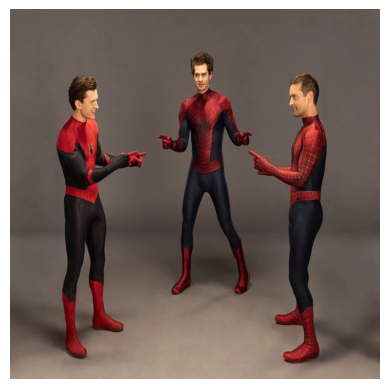

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Let us get the test image to visualize the Anchor boxes

test_img = cv2.imread("spidey.jpg")
test_img = cv2.resize(test_img,(800,800))
cv2.imwrite("meme.jpg",test_img)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
print("Our image is")
plt.imshow(test_img)
plt.axis("off")
plt.show()

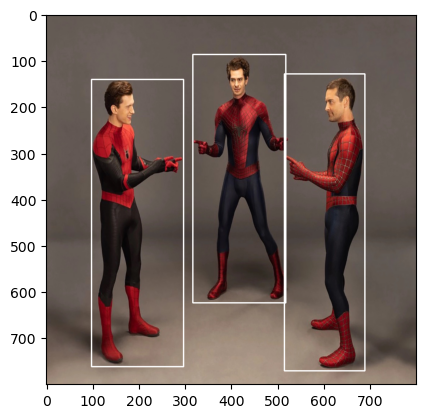

In [2]:
import pandas as pd

labels = pd.read_csv("spidey_labels.csv")
labels['x1'] = labels['bbox_x']
labels['x2'] = labels['bbox_x'] + labels['bbox_width']
labels['y1'] = labels['bbox_y']
labels['y2'] = labels['bbox_y'] + labels['bbox_height']

new_df = labels[['y1','x1','y2','x2']]

clone = test_img.copy()

for s in new_df.values :
    y1,x1,y2,x2 = s
    cv2.rectangle(clone, (x1,y1), (x2,y2), (255,255,255), 2)

    
plt.imshow(clone)
plt.show()

In [3]:
from torchvision.models import vgg16

model = vgg16(weights = 'DEFAULT')
fe = list(model.features)
print("This is the list of all the layers that VGG16 contains")
print(fe)

# NOW WE NEED TO SEE HOW MANY LAYERS OF VGG TO USE
# FOR THIS PURPOSE, WE WILL PASS A DUMMY IMAGE UNTIL IT IS 
# REDUCED TO 1/16 OF ITS ORIGINAL SIZE

k = torch.zeros((1, 3, 800, 800)).float()
req_features = []
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]
    
print()
print()
print("The number of features of VGG16 we require and number of output channels are ")
print(len(req_features)) #30
print(out_channels) # 512

This is the list of all the layers that VGG16 contains
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512

In [4]:
import torch.nn as nn
# Let us now make the backbone of the RPN 

test_img1 = test_img.copy()
fe_extractor = nn.Sequential(*req_features)

test_img1 = torch.tensor(test_img1, dtype = torch.float)
test_img1 = torch.permute(torch.unsqueeze(test_img1, dim = 0),(0,3,1,2))
feature_map = fe_extractor(test_img1)
print(feature_map.shape)

torch.Size([1, 512, 50, 50])


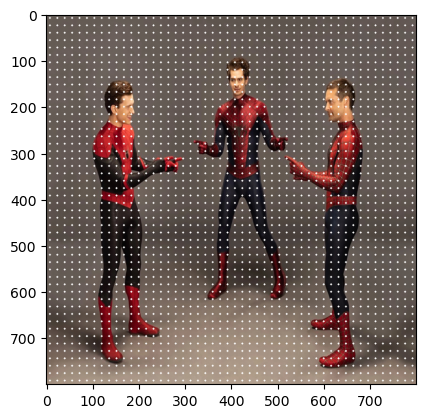

In [5]:
# Now we need to create anchor boxes for all the 
# anchor centres in the feature map

# First let us visualize all the anchor centres in the image

test_img2 = test_img.copy()
centre_x = np.arange(8,800,16)
centre_y = np.arange(8,800,16)

for i in range(len(centre_x)):
    for j in range(len(centre_y)):
        cv2.circle(test_img2, (centre_x[i],centre_y[j]), 2, (255,255,255), -1)
    
plt.imshow(test_img2)
plt.show()

In [6]:
# Time to create anchor boxes 
# But first we need to define scales and aspect ratio for boxes

anchor_scales = [8,16, 32]
aspect_ratios = [0.5, 1 ,2]

# Now we need to create anchor boxes 

anchor_boxes = np.zeros((len(centre_x)*len(centre_y),
                         len(anchor_scales)*len(aspect_ratios), 4),
                        dtype = np.int32)

for p in range(len(centre_x)*len(centre_y)):
    for index in range(len(anchor_scales)*len(aspect_ratios)):
            index_x = p // len(centre_x)
            index_y = p % len(centre_x)
            
            q  = index // len(anchor_scales)
            r  = index % len(aspect_ratios)
            
            h  = 16 * anchor_scales[q] * np.sqrt(aspect_ratios[r])
            w  = 16 * anchor_scales[q] * np.sqrt(1/aspect_ratios[r])
            
            anchor_boxes[p, index, 0] = int(centre_x[index_x] - w / 2)
            anchor_boxes[p, index, 1] = int(centre_y[index_y] - h / 2)
            anchor_boxes[p, index, 2] = int(centre_x[index_x] + w / 2)
            anchor_boxes[p, index, 3] = int(centre_y[index_y] + h / 2)
            

[[[ -82  -37   98   53]
  [ -56  -56   72   72]
  [ -37  -82   53   98]
  ...
  [-354 -173  370  189]
  [-248 -248  264  264]
  [-173 -354  189  370]]

 [[ -82  -21   98   69]
  [ -56  -40   72   88]
  [ -37  -66   53  114]
  ...
  [-354 -157  370  205]
  [-248 -232  264  280]
  [-173 -338  189  386]]

 [[ -82   -5   98   85]
  [ -56  -24   72  104]
  [ -37  -50   53  130]
  ...
  [-354 -141  370  221]
  [-248 -216  264  296]
  [-173 -322  189  402]]

 ...

 [[ 701  714  882  805]
  [ 728  696  856  824]
  [ 746  669  837  850]
  ...
  [ 429  578 1154  941]
  [ 536  504 1048 1016]
  [ 610  397  973 1122]]

 [[ 701  730  882  821]
  [ 728  712  856  840]
  [ 746  685  837  866]
  ...
  [ 429  594 1154  957]
  [ 536  520 1048 1032]
  [ 610  413  973 1138]]

 [[ 701  746  882  837]
  [ 728  728  856  856]
  [ 746  701  837  882]
  ...
  [ 429  610 1154  973]
  [ 536  536 1048 1048]
  [ 610  429  973 1154]]]


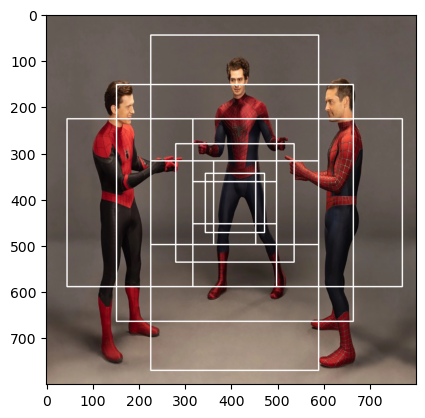

In [7]:
print(anchor_boxes)

# Here -ve sign indicates that the anchor box went out of the picture
# Let us visualize the anchor boxes for the centre of the image

index1 = 50*25 + 25
boxes = anchor_boxes[index1]

test_img3 = test_img.copy()

for a,b,c,d in boxes :
    cv2.rectangle(test_img3,(a,b),(c,d),(255,255,255),2)
    
plt.imshow(test_img3)
plt.show()

In [8]:
#First we need to find the valid anchor boxes

condition = np.logical_and(np.all(anchor_boxes >= 0,axis = 2) , np.all(anchor_boxes <= 800,axis = 2 ))
valid_boxes = anchor_boxes[condition]

# We need to get the indices of the valid boxes as well
indices = np.transpose(np.where(condition))


In [9]:
def iou(boxA, boxB):
       
   # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
   # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
   # compute the area of both the prediction and ground-truth
   # rectangles
    boxAArea = (boxA[2] - boxA[0] ) * (boxA[3] - boxA[1] )
    boxBArea = (boxB[2] - boxB[0] ) * (boxB[3] - boxB[1] )
   
   # compute the intersection over union by taking the intersection
   # area and dividing it by the sum of prediction + ground-truth
   # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
   
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [10]:
# Now we will start working on a dataset instead of a test image
import os 
import pandas as pd
import cv2

path = "/home/web_slinger/Documents/Machine Learning Projects/Object Detection Algorithms/Faster R-CNN"
gt_boxes = []
raccoon_images = []
annotations = pd.read_csv(os.path.join(path, "raccoon_labels.csv"))


for image in os.listdir(os.path.join(path, "images")):
    gt_box = []
    data = cv2.imread(os.path.join(path,"images", image))
    x_scale = 800 / data.shape[0]
    y_scale = 800 / data.shape[1]
    data = cv2.resize(data, (800,800))
    raccoon_images.append(data)
    label_df = annotations[annotations["filename"] == image]
    gt_box = (label_df.values)[:,-4:]
    gt_box[:,0::2] = gt_box[:,0::2] * y_scale
    gt_box[:,1::2] = gt_box[:,1::2] * x_scale 
    gt_boxes.append(gt_box.astype(int))

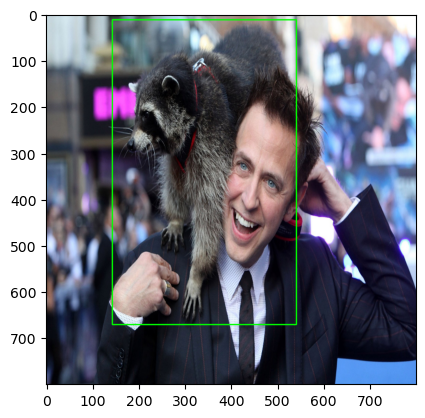

In [11]:
# Let us visualize one of the images and the bounding box

visualize = cv2.cvtColor(raccoon_images[0], cv2.COLOR_BGR2RGB)
cv2.rectangle(visualize,(gt_boxes[0][0,0],gt_boxes[0][0,1]),(gt_boxes[0][0,2],gt_boxes[0][0,3]),(0,255,0),2)
plt.imshow(visualize)
plt.show()

In [12]:
# Now let us create an array containing labels for all the
# valid anchor boxes

labels = np.full((200,valid_boxes.shape[0]), -1)

# we will find the highest iou for each gt_box 
# and its corresponding anchor box so that we will be able 
# to assign postive label for that box
for gt_index in range(len(gt_boxes)) :
    gt_values = gt_boxes[gt_index]
    for gt in gt_values :
        max_iou = 0
        max_index = 0
        for i in range(len(valid_boxes)) :
            box = valid_boxes[i]
            IoU = iou(gt, box)
            if IoU > max_iou :
                max_iou = IoU
                max_index = i
        labels[gt_index,max_index] = 1

In [13]:
# Now we will find the anchor boxes which have iou scores 
# greater than postive threshold or iou scores less than 
# negative threshold

pos_threshold = 0.7
neg_threshold = 0.3
max_ious = np.empty((200, 8940,4))

for gt_index in range(len(gt_boxes)):
    gt_values = gt_boxes[gt_index]
    for i in range(len(valid_boxes)):
        box =  valid_boxes[i]
        max_iou = 0
        max_index = 0
        for j in range(len(gt_values)) :
            gt = gt_values[j]
            IoU = iou(gt, box)
            if IoU > max_iou :
                max_iou = IoU
                max_index = j
        max_ious[gt_index, i] = gt_values[max_index]
        if max_iou >= pos_threshold :
            labels[gt_index, i] = 1
            
        elif max_iou < neg_threshold :
            labels[gt_index, i] = 0

In [16]:
# Now we will need 256 total samples to feed the rpn from each image

# We will divide the samples equally by taking 128 positive samples
# and 128 negative samples

n_pos = 50
for i in range(len(labels)):
    pos_index = np.where(labels[i] == 1)[0]
    if len(pos_index) > n_pos :
        disable_index = np.random.choice(pos_index,
                                         size = (len(pos_index) - n_pos),replace = False)
        labels[i][disable_index] = -1
        
    n_neg = 100 - np.sum(labels[i] == 1)
    neg_index = np.where(labels[i] == 0)[0]
    
    if len(neg_index) > n_neg:
        disable_index = np.random.choice(neg_index, 
                                         size = (len(neg_index) - n_neg), replace = False)
        labels[i][disable_index] = -1

In [17]:
# Now we need to parametrize to find the position of the 
# anchor box with respect to the ground truth boxes

height = valid_boxes[:, 2] - valid_boxes[:, 0]
width = valid_boxes[:, 3] - valid_boxes[:, 1]
ctr_y = valid_boxes[:, 0] + 0.5 * height
ctr_x = valid_boxes[:, 1] + 0.5 * width

final_anchors = np.empty((200,8940, 4))
for i in range(200):
    max_iou_bbox = max_ious[i]
    base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
    base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
    base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
    base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width
    
    dy = (base_ctr_y - ctr_y) / height
    dx = (base_ctr_x - ctr_x) / width
    dh = np.log(base_height / height)
    dw = np.log(base_width / width) 
    anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
    final_anchors[i] = anchor_locs

In [18]:
anchor_labels = np.empty((200,22500), dtype = labels.dtype)
anchor_labels.fill(-1)
valid_indices = [p[0]*9 + p[1] for p in indices]
anchor_labels[:,valid_indices] = labels

In [19]:
anchor_locations = np.empty((200,22500,4))
anchor_locations.fill(0)
anchor_locations[:,valid_indices] = final_anchors

In [20]:
# we need to make custom loss function for the bounding box offsets and objectness scores

from torch.nn.functional import smooth_l1_loss, binary_cross_entropy

def custom_l1_loss(pred, target, target_label):
    assert (len(pred) == 22500 and len(pred[0]) == 4)
    indices = (target_label == 1).nonzero()
    valid_preds = pred[indices]
    target_locs =  target[indices]
    l1_loss = smooth_l1_loss(valid_preds, target_locs)
    return torch.mean(l1_loss)

def binary_loss(preds, target_labels):
    assert len(preds) == 22500
    indices = (target_labels != -1).nonzero()
    predictions = preds[indices]
    target = target_labels[indices]
    bce_loss = binary_cross_entropy(predictions, target)
    return bce_loss

In [21]:
# Time to make the model RPN

class rpn(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(512, 512, 3, 1, 1)
        self.reg_head = nn.Conv2d(512, 36, 1, 1, 0)
        self.cls_head = nn.Conv2d(512, 9, 1, 1, 0)
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, feature_map):
        output = self.relu(self.layer1(feature_map))
        reg_out = self.relu(self.reg_head(output))
        reg_out = self.flatten(reg_out)
        reg_out = reg_out.view(-1,4)
        cls_out = self.sigmoid(self.cls_head(output))
        cls_out =  self.flatten(cls_out)
        
        return cls_out, reg_out

In [22]:
# First let us convert the array to tensor
from torch.utils.data import DataLoader,Dataset

anchor_locations = torch.tensor(anchor_locations, dtype = torch.int32)
anchor_labels = torch.tensor(anchor_labels, dtype = torch.float32)

raccoon_images = torch.tensor(raccoon_images, dtype = torch.float32)

/tmp/ipykernel_6234/3584874344.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/torch/csrc/utils/tensor_new.cpp:230.)
  raccoon_images = torch.tensor(raccoon_images, dtype = torch.float32)


In [23]:
# Let us fix the hyperparameters for the model

epochs = 10
lr = 0.001
model = rpn()
optim = torch.optim.Adam(model.parameters(), lr = lr)

In [24]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else :
    device = torch.device('cpu')
    
fe_extractor.to(device)
model.to(device)

rpn(
  (layer1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (reg_head): Conv2d(512, 36, kernel_size=(1, 1), stride=(1, 1))
  (cls_head): Conv2d(512, 9, kernel_size=(1, 1), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

In [25]:
for epoch in range(epochs):
    for i in range(len(raccoon_images)):
        raccoon_image = torch.unsqueeze(raccoon_images[i], dim = 0)
        offsets = anchor_locations[i]
        classes = anchor_labels[i]
        raccoon_image = torch.permute(raccoon_image, (0,3,1,2))
        raccoon_image,offsets,classes = raccoon_image.to(device),offsets.to(device),classes.to(device)
        features = fe_extractor(raccoon_image)
        optim.zero_grad()
        cls_output, reg_output = model(features)
        cls_loss = binary_loss(cls_output[0], classes)
        reg_loss = custom_l1_loss(reg_output, offsets, classes)
        total_loss = cls_loss + reg_loss
        total_loss.backward()
        optim.step()
        print("For epoch number {} and image number {}".format(epoch+1,i+1))
        print("The classification loss {}, the smooth l1 loss {}".format(cls_loss, reg_loss))

For epoch number 1 and image number 1
The classification loss 0.927933931350708, the smooth l1 loss 1.6997852325439453
For epoch number 1 and image number 2
The classification loss 0.47730544209480286, the smooth l1 loss 0.0
For epoch number 1 and image number 3
The classification loss 2.4997591972351074, the smooth l1 loss 0.3034285604953766
For epoch number 1 and image number 4
The classification loss 1.2514512538909912, the smooth l1 loss 0.06465256959199905
For epoch number 1 and image number 5
The classification loss 0.695932924747467, the smooth l1 loss 0.021415939554572105
For epoch number 1 and image number 6
The classification loss 1.2386243343353271, the smooth l1 loss 0.00045663450146093965
For epoch number 1 and image number 7
The classification loss 1.8054406642913818, the smooth l1 loss 0.0
For epoch number 1 and image number 8
The classification loss 0.48569193482398987, the smooth l1 loss 0.0
For epoch number 1 and image number 9
The classification loss 0.67051464319229

The classification loss 0.6382123231887817, the smooth l1 loss 0.0
For epoch number 1 and image number 78
The classification loss 1.1465619802474976, the smooth l1 loss 0.0
For epoch number 1 and image number 79
The classification loss 1.8242340087890625, the smooth l1 loss 0.0
For epoch number 1 and image number 80
The classification loss 0.2659432888031006, the smooth l1 loss 0.0
For epoch number 1 and image number 81
The classification loss 0.06716227531433105, the smooth l1 loss 0.0
For epoch number 1 and image number 82
The classification loss 0.19044311344623566, the smooth l1 loss 0.0
For epoch number 1 and image number 83
The classification loss 0.13794086873531342, the smooth l1 loss 0.0
For epoch number 1 and image number 84
The classification loss 0.185643270611763, the smooth l1 loss 0.0
For epoch number 1 and image number 85
The classification loss 0.20559269189834595, the smooth l1 loss 0.0
For epoch number 1 and image number 86
The classification loss 0.10010715574026108

The classification loss 1.6248626708984375, the smooth l1 loss 0.009170454926788807
For epoch number 1 and image number 154
The classification loss 0.11419504135847092, the smooth l1 loss 0.0
For epoch number 1 and image number 155
The classification loss 0.1074736937880516, the smooth l1 loss 0.0
For epoch number 1 and image number 156
The classification loss 1.1546753644943237, the smooth l1 loss 0.0
For epoch number 1 and image number 157
The classification loss 0.1690921187400818, the smooth l1 loss 0.0
For epoch number 1 and image number 158
The classification loss 0.15507754683494568, the smooth l1 loss 0.0
For epoch number 1 and image number 159
The classification loss 0.08965802192687988, the smooth l1 loss 0.0
For epoch number 1 and image number 160
The classification loss 0.11091102659702301, the smooth l1 loss 0.0
For epoch number 1 and image number 161
The classification loss 0.8464589715003967, the smooth l1 loss 0.0
For epoch number 1 and image number 162
The classificati

The classification loss 0.18948309123516083, the smooth l1 loss 0.0
For epoch number 2 and image number 29
The classification loss 0.5467321872711182, the smooth l1 loss 0.0
For epoch number 2 and image number 30
The classification loss 0.6465413570404053, the smooth l1 loss 0.0
For epoch number 2 and image number 31
The classification loss 0.08482007682323456, the smooth l1 loss 0.0
For epoch number 2 and image number 32
The classification loss 0.15491053462028503, the smooth l1 loss 0.0
For epoch number 2 and image number 33
The classification loss 0.17655441164970398, the smooth l1 loss 0.0
For epoch number 2 and image number 34
The classification loss 0.8200926184654236, the smooth l1 loss 0.0
For epoch number 2 and image number 35
The classification loss 0.3980516791343689, the smooth l1 loss 0.0
For epoch number 2 and image number 36
The classification loss 0.20513656735420227, the smooth l1 loss 0.0
For epoch number 2 and image number 37
The classification loss 0.257912039756774

The classification loss 0.17748944461345673, the smooth l1 loss 0.0
For epoch number 2 and image number 105
The classification loss 1.463623285293579, the smooth l1 loss 0.0006254143663682044
For epoch number 2 and image number 106
The classification loss 0.47697892785072327, the smooth l1 loss 0.0
For epoch number 2 and image number 107
The classification loss 0.19171224534511566, the smooth l1 loss 0.0
For epoch number 2 and image number 108
The classification loss 0.3587746322154999, the smooth l1 loss 0.0
For epoch number 2 and image number 109
The classification loss 0.24327102303504944, the smooth l1 loss 0.0
For epoch number 2 and image number 110
The classification loss 1.373348355293274, the smooth l1 loss 0.0
For epoch number 2 and image number 111
The classification loss 0.37164610624313354, the smooth l1 loss 0.0
For epoch number 2 and image number 112
The classification loss 0.38390177488327026, the smooth l1 loss 0.0
For epoch number 2 and image number 113
The classificat

For epoch number 2 and image number 180
The classification loss 0.2525975704193115, the smooth l1 loss 0.0
For epoch number 2 and image number 181
The classification loss 0.23232650756835938, the smooth l1 loss 0.0
For epoch number 2 and image number 182
The classification loss 0.8135697245597839, the smooth l1 loss 0.0
For epoch number 2 and image number 183
The classification loss 0.15315042436122894, the smooth l1 loss 0.0
For epoch number 2 and image number 184
The classification loss 0.16158784925937653, the smooth l1 loss 0.0
For epoch number 2 and image number 185
The classification loss 0.2075970470905304, the smooth l1 loss 0.0
For epoch number 2 and image number 186
The classification loss 0.28701192140579224, the smooth l1 loss 0.0
For epoch number 2 and image number 187
The classification loss 0.7672233581542969, the smooth l1 loss 0.0
For epoch number 2 and image number 188
The classification loss 0.22501476109027863, the smooth l1 loss 0.0
For epoch number 2 and image num

The classification loss 0.2766735255718231, the smooth l1 loss 0.0
For epoch number 3 and image number 57
The classification loss 0.3730534017086029, the smooth l1 loss 0.0
For epoch number 3 and image number 58
The classification loss 0.19251002371311188, the smooth l1 loss 0.0
For epoch number 3 and image number 59
The classification loss 0.13353076577186584, the smooth l1 loss 0.0
For epoch number 3 and image number 60
The classification loss 0.33512938022613525, the smooth l1 loss 0.0
For epoch number 3 and image number 61
The classification loss 0.36202341318130493, the smooth l1 loss 0.0
For epoch number 3 and image number 62
The classification loss 0.2514280378818512, the smooth l1 loss 0.0
For epoch number 3 and image number 63
The classification loss 0.6609125137329102, the smooth l1 loss 0.0
For epoch number 3 and image number 64
The classification loss 0.3002673387527466, the smooth l1 loss 0.0
For epoch number 3 and image number 65
The classification loss 0.1462898254394531

The classification loss 0.2510981559753418, the smooth l1 loss 0.0
For epoch number 3 and image number 133
The classification loss 0.2928960621356964, the smooth l1 loss 0.0
For epoch number 3 and image number 134
The classification loss 0.44583791494369507, the smooth l1 loss 0.0
For epoch number 3 and image number 135
The classification loss 0.5592921376228333, the smooth l1 loss 0.0
For epoch number 3 and image number 136
The classification loss 0.41836583614349365, the smooth l1 loss 0.0
For epoch number 3 and image number 137
The classification loss 0.49611610174179077, the smooth l1 loss 0.0
For epoch number 3 and image number 138
The classification loss 0.07885561883449554, the smooth l1 loss 0.0
For epoch number 3 and image number 139
The classification loss 0.5039840340614319, the smooth l1 loss 0.0
For epoch number 3 and image number 140
The classification loss 0.3324442207813263, the smooth l1 loss 0.0
For epoch number 3 and image number 141
The classification loss 0.0830399

For epoch number 4 and image number 9
The classification loss 0.43901526927948, the smooth l1 loss 0.0
For epoch number 4 and image number 10
The classification loss 0.20095227658748627, the smooth l1 loss 0.0
For epoch number 4 and image number 11
The classification loss 0.2885253131389618, the smooth l1 loss 0.0
For epoch number 4 and image number 12
The classification loss 0.23571036756038666, the smooth l1 loss 0.0
For epoch number 4 and image number 13
The classification loss 0.19300825893878937, the smooth l1 loss 0.0
For epoch number 4 and image number 14
The classification loss 0.11222589015960693, the smooth l1 loss 0.0
For epoch number 4 and image number 15
The classification loss 0.1654549241065979, the smooth l1 loss 0.0
For epoch number 4 and image number 16
The classification loss 0.34292417764663696, the smooth l1 loss 0.0
For epoch number 4 and image number 17
The classification loss 0.19588738679885864, the smooth l1 loss 0.0
For epoch number 4 and image number 18
The 

The classification loss 0.14089585840702057, the smooth l1 loss 0.0
For epoch number 4 and image number 87
The classification loss 0.46805450320243835, the smooth l1 loss 0.0
For epoch number 4 and image number 88
The classification loss 0.29249095916748047, the smooth l1 loss 0.0
For epoch number 4 and image number 89
The classification loss 0.38949522376060486, the smooth l1 loss 0.0
For epoch number 4 and image number 90
The classification loss 0.19199992716312408, the smooth l1 loss 0.0
For epoch number 4 and image number 91
The classification loss 0.14289160072803497, the smooth l1 loss 0.0
For epoch number 4 and image number 92
The classification loss 0.9789056181907654, the smooth l1 loss 0.0
For epoch number 4 and image number 93
The classification loss 0.131760835647583, the smooth l1 loss 0.0
For epoch number 4 and image number 94
The classification loss 0.08346971124410629, the smooth l1 loss 0.0
For epoch number 4 and image number 95
The classification loss 0.70873248577117

The classification loss 0.5348436832427979, the smooth l1 loss 0.0
For epoch number 4 and image number 163
The classification loss 0.20833249390125275, the smooth l1 loss 0.0
For epoch number 4 and image number 164
The classification loss 0.12675786018371582, the smooth l1 loss 0.0
For epoch number 4 and image number 165
The classification loss 0.3959644138813019, the smooth l1 loss 0.0
For epoch number 4 and image number 166
The classification loss 0.51063072681427, the smooth l1 loss 0.0
For epoch number 4 and image number 167
The classification loss 0.10591702908277512, the smooth l1 loss 0.0
For epoch number 4 and image number 168
The classification loss 0.12093259394168854, the smooth l1 loss 0.0
For epoch number 4 and image number 169
The classification loss 0.2493085116147995, the smooth l1 loss 0.0
For epoch number 4 and image number 170
The classification loss 0.35520878434181213, the smooth l1 loss 0.0
For epoch number 4 and image number 171
The classification loss 0.56139516

The classification loss 0.37189626693725586, the smooth l1 loss 0.0
For epoch number 5 and image number 40
The classification loss 0.29156991839408875, the smooth l1 loss 0.0
For epoch number 5 and image number 41
The classification loss 0.5857526063919067, the smooth l1 loss 0.0
For epoch number 5 and image number 42
The classification loss 0.18756048381328583, the smooth l1 loss 0.0
For epoch number 5 and image number 43
The classification loss 0.12146678566932678, the smooth l1 loss 0.0
For epoch number 5 and image number 44
The classification loss 0.32602939009666443, the smooth l1 loss 0.0
For epoch number 5 and image number 45
The classification loss 0.19491170346736908, the smooth l1 loss 0.0
For epoch number 5 and image number 46
The classification loss 0.19587776064872742, the smooth l1 loss 0.0
For epoch number 5 and image number 47
The classification loss 0.2834557294845581, the smooth l1 loss 0.0
For epoch number 5 and image number 48
The classification loss 0.3376689553260

The classification loss 0.15533556044101715, the smooth l1 loss 0.0
For epoch number 5 and image number 117
The classification loss 0.13136373460292816, the smooth l1 loss 0.0
For epoch number 5 and image number 118
The classification loss 0.20583102107048035, the smooth l1 loss 0.0
For epoch number 5 and image number 119
The classification loss 0.13672398030757904, the smooth l1 loss 0.0
For epoch number 5 and image number 120
The classification loss 0.24421045184135437, the smooth l1 loss 0.0
For epoch number 5 and image number 121
The classification loss 0.19148880243301392, the smooth l1 loss 0.0
For epoch number 5 and image number 122
The classification loss 0.2694109380245209, the smooth l1 loss 0.0
For epoch number 5 and image number 123
The classification loss 0.3703956604003906, the smooth l1 loss 0.0
For epoch number 5 and image number 124
The classification loss 0.4679037630558014, the smooth l1 loss 0.0
For epoch number 5 and image number 125
The classification loss 0.26355

The classification loss 0.36732497811317444, the smooth l1 loss 0.0
For epoch number 5 and image number 194
The classification loss 0.20644836127758026, the smooth l1 loss 0.0
For epoch number 5 and image number 195
The classification loss 0.149927020072937, the smooth l1 loss 0.0
For epoch number 5 and image number 196
The classification loss 0.1862216591835022, the smooth l1 loss 0.0
For epoch number 5 and image number 197
The classification loss 0.1295778453350067, the smooth l1 loss 0.0
For epoch number 5 and image number 198
The classification loss 0.08585258573293686, the smooth l1 loss 0.0
For epoch number 5 and image number 199
The classification loss 0.3239287734031677, the smooth l1 loss 0.0
For epoch number 5 and image number 200
The classification loss 0.40492889285087585, the smooth l1 loss 0.0
For epoch number 6 and image number 1
The classification loss 0.07607041299343109, the smooth l1 loss 0.0
For epoch number 6 and image number 2
The classification loss 0.05242584645

The classification loss 0.1465456336736679, the smooth l1 loss 0.0
For epoch number 6 and image number 71
The classification loss 0.10513314604759216, the smooth l1 loss 0.0
For epoch number 6 and image number 72
The classification loss 0.12820620834827423, the smooth l1 loss 0.0
For epoch number 6 and image number 73
The classification loss 0.07449052482843399, the smooth l1 loss 0.0
For epoch number 6 and image number 74
The classification loss 0.2944800555706024, the smooth l1 loss 0.0
For epoch number 6 and image number 75
The classification loss 0.03422882407903671, the smooth l1 loss 0.0
For epoch number 6 and image number 76
The classification loss 0.17050282657146454, the smooth l1 loss 0.0
For epoch number 6 and image number 77
The classification loss 0.14263497292995453, the smooth l1 loss 0.0
For epoch number 6 and image number 78
The classification loss 0.23658207058906555, the smooth l1 loss 0.0
For epoch number 6 and image number 79
The classification loss 0.6450437307357

The classification loss 0.3776848614215851, the smooth l1 loss 0.0
For epoch number 6 and image number 148
The classification loss 0.11517765372991562, the smooth l1 loss 0.0
For epoch number 6 and image number 149
The classification loss 0.30855175852775574, the smooth l1 loss 0.0
For epoch number 6 and image number 150
The classification loss 0.147101491689682, the smooth l1 loss 0.0
For epoch number 6 and image number 151
The classification loss 0.2857802212238312, the smooth l1 loss 0.0
For epoch number 6 and image number 152
The classification loss 0.07173098623752594, the smooth l1 loss 0.0
For epoch number 6 and image number 153
The classification loss 0.6898906826972961, the smooth l1 loss 2.6403198717162013e-05
For epoch number 6 and image number 154
The classification loss 0.10688570141792297, the smooth l1 loss 0.0
For epoch number 6 and image number 155
The classification loss 0.06716334819793701, the smooth l1 loss 0.0
For epoch number 6 and image number 156
The classifica

The classification loss 0.650935709476471, the smooth l1 loss 0.0
For epoch number 7 and image number 24
The classification loss 0.12328120321035385, the smooth l1 loss 0.0
For epoch number 7 and image number 25
The classification loss 0.07451402395963669, the smooth l1 loss 0.0
For epoch number 7 and image number 26
The classification loss 0.10245801508426666, the smooth l1 loss 0.0
For epoch number 7 and image number 27
The classification loss 0.2475261241197586, the smooth l1 loss 0.0
For epoch number 7 and image number 28
The classification loss 0.07698211073875427, the smooth l1 loss 0.0
For epoch number 7 and image number 29
The classification loss 0.26267117261886597, the smooth l1 loss 0.0
For epoch number 7 and image number 30
The classification loss 0.31352499127388, the smooth l1 loss 0.0
For epoch number 7 and image number 31
The classification loss 0.03258770331740379, the smooth l1 loss 0.0
For epoch number 7 and image number 32
The classification loss 0.05789630860090256

The classification loss 0.08523862063884735, the smooth l1 loss 0.0
For epoch number 7 and image number 101
The classification loss 0.03672533854842186, the smooth l1 loss 0.0
For epoch number 7 and image number 102
The classification loss 0.4358586072921753, the smooth l1 loss 0.0
For epoch number 7 and image number 103
The classification loss 0.21121446788311005, the smooth l1 loss 0.0
For epoch number 7 and image number 104
The classification loss 0.17828257381916046, the smooth l1 loss 0.0
For epoch number 7 and image number 105
The classification loss 0.6214113831520081, the smooth l1 loss 0.0
For epoch number 7 and image number 106
The classification loss 0.15014655888080597, the smooth l1 loss 0.0
For epoch number 7 and image number 107
The classification loss 0.15964418649673462, the smooth l1 loss 0.0
For epoch number 7 and image number 108
The classification loss 0.18160270154476166, the smooth l1 loss 0.0
For epoch number 7 and image number 109
The classification loss 0.1355

The classification loss 0.2283739596605301, the smooth l1 loss 0.0
For epoch number 7 and image number 177
The classification loss 0.1723846197128296, the smooth l1 loss 0.0
For epoch number 7 and image number 178
The classification loss 0.0966886505484581, the smooth l1 loss 0.0
For epoch number 7 and image number 179
The classification loss 0.17064009606838226, the smooth l1 loss 0.0
For epoch number 7 and image number 180
The classification loss 0.15034723281860352, the smooth l1 loss 0.0
For epoch number 7 and image number 181
The classification loss 0.1318977177143097, the smooth l1 loss 0.0
For epoch number 7 and image number 182
The classification loss 0.449238121509552, the smooth l1 loss 0.0
For epoch number 7 and image number 183
The classification loss 0.11454248428344727, the smooth l1 loss 0.0
For epoch number 7 and image number 184
The classification loss 0.11836425215005875, the smooth l1 loss 0.0
For epoch number 7 and image number 185
The classification loss 0.10842769

The classification loss 0.2590492069721222, the smooth l1 loss 0.0
For epoch number 8 and image number 54
The classification loss 0.32145416736602783, the smooth l1 loss 0.0
For epoch number 8 and image number 55
The classification loss 0.3063690960407257, the smooth l1 loss 0.0
For epoch number 8 and image number 56
The classification loss 0.12499046325683594, the smooth l1 loss 0.0
For epoch number 8 and image number 57
The classification loss 0.18716922402381897, the smooth l1 loss 0.0
For epoch number 8 and image number 58
The classification loss 0.09177937358617783, the smooth l1 loss 0.0
For epoch number 8 and image number 59
The classification loss 0.062013644725084305, the smooth l1 loss 0.0
For epoch number 8 and image number 60
The classification loss 0.2260357290506363, the smooth l1 loss 0.0
For epoch number 8 and image number 61
The classification loss 0.16031885147094727, the smooth l1 loss 0.0
For epoch number 8 and image number 62
The classification loss 0.1235138848423

The classification loss 0.17475350201129913, the smooth l1 loss 0.0
For epoch number 8 and image number 130
The classification loss 0.23781818151474, the smooth l1 loss 0.0
For epoch number 8 and image number 131
The classification loss 0.16391631960868835, the smooth l1 loss 0.0
For epoch number 8 and image number 132
The classification loss 0.22542530298233032, the smooth l1 loss 0.0
For epoch number 8 and image number 133
The classification loss 0.11320992559194565, the smooth l1 loss 0.0
For epoch number 8 and image number 134
The classification loss 0.22315600514411926, the smooth l1 loss 0.0
For epoch number 8 and image number 135
The classification loss 0.30728664994239807, the smooth l1 loss 0.0
For epoch number 8 and image number 136
The classification loss 0.2569922208786011, the smooth l1 loss 0.0
For epoch number 8 and image number 137
The classification loss 0.22698752582073212, the smooth l1 loss 0.0
For epoch number 8 and image number 138
The classification loss 0.013633

The classification loss 0.16322416067123413, the smooth l1 loss 0.0
For epoch number 9 and image number 7
The classification loss 0.036136023700237274, the smooth l1 loss 0.0
For epoch number 9 and image number 8
The classification loss 0.02803029678761959, the smooth l1 loss 0.0
For epoch number 9 and image number 9
The classification loss 0.3116009831428528, the smooth l1 loss 0.0
For epoch number 9 and image number 10
The classification loss 0.14862217009067535, the smooth l1 loss 0.0
For epoch number 9 and image number 11
The classification loss 0.22203591465950012, the smooth l1 loss 0.0
For epoch number 9 and image number 12
The classification loss 0.09731807559728622, the smooth l1 loss 0.0
For epoch number 9 and image number 13
The classification loss 0.12580989301204681, the smooth l1 loss 0.0
For epoch number 9 and image number 14
The classification loss 0.04062322527170181, the smooth l1 loss 0.0
For epoch number 9 and image number 15
The classification loss 0.11859950423240

The classification loss 0.081767737865448, the smooth l1 loss 0.0
For epoch number 9 and image number 84
The classification loss 0.05304640159010887, the smooth l1 loss 0.0
For epoch number 9 and image number 85
The classification loss 0.1669345647096634, the smooth l1 loss 0.0
For epoch number 9 and image number 86
The classification loss 0.06512366235256195, the smooth l1 loss 0.0
For epoch number 9 and image number 87
The classification loss 0.1561298370361328, the smooth l1 loss 0.0
For epoch number 9 and image number 88
The classification loss 0.22566257417201996, the smooth l1 loss 0.0
For epoch number 9 and image number 89
The classification loss 0.18032318353652954, the smooth l1 loss 0.0
For epoch number 9 and image number 90
The classification loss 0.07575833052396774, the smooth l1 loss 0.0
For epoch number 9 and image number 91
The classification loss 0.06816109269857407, the smooth l1 loss 0.0
For epoch number 9 and image number 92
The classification loss 0.428399384021759

The classification loss 0.05515310540795326, the smooth l1 loss 0.0
For epoch number 9 and image number 160
The classification loss 0.10276695340871811, the smooth l1 loss 0.0
For epoch number 9 and image number 161
The classification loss 0.19134123623371124, the smooth l1 loss 0.0
For epoch number 9 and image number 162
The classification loss 0.22075441479682922, the smooth l1 loss 0.0
For epoch number 9 and image number 163
The classification loss 0.1477653533220291, the smooth l1 loss 0.0
For epoch number 9 and image number 164
The classification loss 0.15853199362754822, the smooth l1 loss 0.0
For epoch number 9 and image number 165
The classification loss 0.10245656967163086, the smooth l1 loss 0.0
For epoch number 9 and image number 166
The classification loss 0.18801577389240265, the smooth l1 loss 0.0
For epoch number 9 and image number 167
The classification loss 0.0331234410405159, the smooth l1 loss 0.0
For epoch number 9 and image number 168
The classification loss 0.0606

The classification loss 0.034046851098537445, the smooth l1 loss 0.0
For epoch number 10 and image number 37
The classification loss 0.09365817159414291, the smooth l1 loss 0.0
For epoch number 10 and image number 38
The classification loss 0.19091349840164185, the smooth l1 loss 0.0
For epoch number 10 and image number 39
The classification loss 0.16377395391464233, the smooth l1 loss 0.0
For epoch number 10 and image number 40
The classification loss 0.19712986052036285, the smooth l1 loss 0.0
For epoch number 10 and image number 41
The classification loss 0.25520962476730347, the smooth l1 loss 0.0
For epoch number 10 and image number 42
The classification loss 0.05270238593220711, the smooth l1 loss 0.0
For epoch number 10 and image number 43
The classification loss 0.03840614855289459, the smooth l1 loss 0.0
For epoch number 10 and image number 44
The classification loss 0.20192788541316986, the smooth l1 loss 0.0
For epoch number 10 and image number 45
The classification loss 0.0

The classification loss 0.18621879816055298, the smooth l1 loss 0.0
For epoch number 10 and image number 113
The classification loss 0.09656953811645508, the smooth l1 loss 0.0
For epoch number 10 and image number 114
The classification loss 0.12082183361053467, the smooth l1 loss 0.0
For epoch number 10 and image number 115
The classification loss 0.25676876306533813, the smooth l1 loss 0.0
For epoch number 10 and image number 116
The classification loss 0.038727808743715286, the smooth l1 loss 0.0
For epoch number 10 and image number 117
The classification loss 0.06652436405420303, the smooth l1 loss 0.0
For epoch number 10 and image number 118
The classification loss 0.0701093003153801, the smooth l1 loss 0.0
For epoch number 10 and image number 119
The classification loss 0.06447954475879669, the smooth l1 loss 0.0
For epoch number 10 and image number 120
The classification loss 0.041234638541936874, the smooth l1 loss 0.0
For epoch number 10 and image number 121
The classification

The classification loss 0.232106015086174, the smooth l1 loss 0.0
For epoch number 10 and image number 188
The classification loss 0.03798805922269821, the smooth l1 loss 0.0
For epoch number 10 and image number 189
The classification loss 0.030515065416693687, the smooth l1 loss 0.0
For epoch number 10 and image number 190
The classification loss 0.10274182260036469, the smooth l1 loss 0.0
For epoch number 10 and image number 191
The classification loss 0.18476226925849915, the smooth l1 loss 0.0
For epoch number 10 and image number 192
The classification loss 0.16447925567626953, the smooth l1 loss 0.0
For epoch number 10 and image number 193
The classification loss 0.14667783677577972, the smooth l1 loss 0.0
For epoch number 10 and image number 194
The classification loss 0.0817418098449707, the smooth l1 loss 0.0
For epoch number 10 and image number 195
The classification loss 0.1045282706618309, the smooth l1 loss 0.0
For epoch number 10 and image number 196
The classification los